<a href="https://colab.research.google.com/github/FernandaSzAdr/KNN_cromossome/blob/master/TesteRede2_Colorida_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/




---



In [2]:
import os
import cv2
import csv
!pip install imutils
import imutils
from skimage import transform
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import itertools
import matplotlib.pyplot as plt

  Running setup.py bdist_wheel for imutils ... - \ done
  Stored in directory: /root/.cache/pip/wheels/4c/ff/aa/824fb9efc5b8c740d54cd8bc19c7e85fbb8d115c77e56812c7
Successfully built imutils


Using TensorFlow backend.




---



## Funções

In [0]:
train_path = 'drive/My Drive/Base_CNN/Colorido2/Train'
test_path = 'drive/My Drive/Base_CNN/Colorido2/Test'
validation_path = 'drive/My Drive/Base_CNN/Colorido2/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Base_CNN/Colorido2/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    image = imutils.resize(image, width=1000)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(1)
            else:
              y_true.append(0)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            # Se é um cromossomo:
            if predicao[0][0] > predicao[0][1]:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict




---



## Implementação



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [9]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 4369 images belonging to 2 classes.
Found 991 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [11]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



### 1 tentativa Precision: 0.00%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_1'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [114]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.7503 - acc: 0.4688 - val_loss: 0.6922 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 0.69216, saving model to drive/My Drive/Resultado/weights_architecture_1.hdf5
Epoch 2/50
 - 1s - loss: 0.7224 - acc: 0.4875 - val_loss: 0.7067 - val_acc: 0.4062

Epoch 00002: val_loss did not improve from 0.69216
Epoch 3/50
 - 1s - loss: 0.6923 - acc: 0.5500 - val_loss: 0.7001 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.69216
Epoch 4/50
 - 1s - loss: 0.6747 - acc: 0.5938 - val_loss: 0.8005 - val_acc: 0.3750

Epoch 00004: val_loss did not improve from 0.69216
Epoch 5/50
 - 1s - loss: 0.7339 - acc: 0.4375 - val_loss: 0.7194 - val_acc: 0.4062

Epoch 00005: val_loss did not improve from 0.69216
Epoch 6/50
 - 1s - loss: 0.6987 - acc: 0.5625 - val_loss: 0.6901 - val_acc: 0.5625

Epoch 00006: val_loss improved from 0.69216 to 0.69007, saving model to drive/My Drive/Resultado/weights_architecture_1.hdf5
Epoch 7/50
 - 1s - loss: 0.6820 - acc: 0.5500 

In [0]:
model.load_weights('drive/My Drive/Resultado/weights_architecture_1.hdf5')

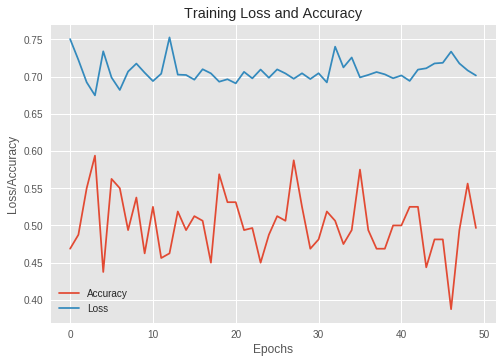

In [116]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [117]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [118]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 0.00%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)




---



### 2 tentativa  Precision: 73.14%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_2'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [123]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 0.6930 - acc: 0.4937 - val_loss: 0.6930 - val_acc: 0.4375

Epoch 00001: val_loss improved from inf to 0.69301, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6926 - acc: 0.6063 - val_loss: 0.6929 - val_acc: 0.4688

Epoch 00002: val_loss improved from 0.69301 to 0.69290, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 3/50
 - 1s - loss: 0.6921 - acc: 0.6625 - val_loss: 0.6909 - val_acc: 0.6250

Epoch 00003: val_loss improved from 0.69290 to 0.69088, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6941 - acc: 0.4250 - val_loss: 0.6924 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.69088
Epoch 5/50
 - 1s - loss: 0.6917 - acc: 0.6688 - val_loss: 0.6925 - val_acc: 0.5625

Epoch 00005: val_loss did not improve from 0.69088
Epoch 6/50
 - 1s - loss: 0.6919 - acc: 0.5875 - val_loss: 0.6909 - val_acc: 0.5312

Epoch 00006: val_loss d

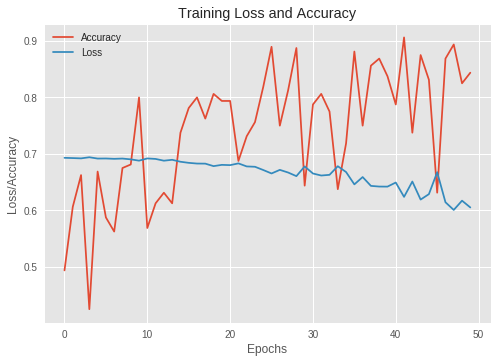

In [124]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [125]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [126]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 73.14%


### 3 tentativa Precision: 76.40%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_3'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [131]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 0.7080 - acc: 0.7409 - val_loss: 0.4686 - val_acc: 0.7969

Epoch 00001: val_loss improved from inf to 0.46861, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 0.5140 - acc: 0.8312 - val_loss: 0.7639 - val_acc: 0.7344

Epoch 00002: val_loss did not improve from 0.46861
Epoch 3/50
 - 0s - loss: 0.5224 - acc: 0.8375 - val_loss: 0.4423 - val_acc: 0.7969

Epoch 00003: val_loss improved from 0.46861 to 0.44228, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 4/50
 - 0s - loss: 0.3518 - acc: 0.8812 - val_loss: 0.3331 - val_acc: 0.8438

Epoch 00004: val_loss improved from 0.44228 to 0.33312, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 5/50
 - 0s - loss: 0.3499 - acc: 0.8812 - val_loss: 0.8334 - val_acc: 0.6875

Epoch 00005: val_loss did not improve from 0.33312
Epoch 6/50
 - 0s - loss: 0.4731 - acc: 0.8375 - val_loss: 0.3826 - val_acc: 0.8281

Epoch 00006: val_loss d

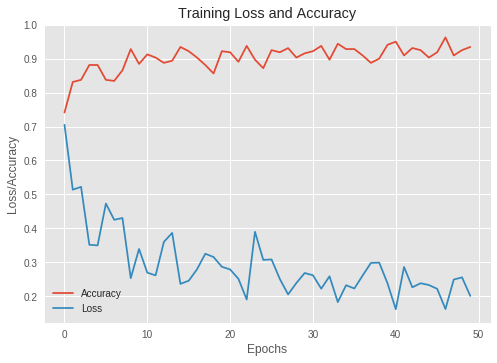

In [132]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [133]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [134]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 76.40%


### 4 tentativa Precision: 58.29%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_4'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [139]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 0.5043 - acc: 0.7687 - val_loss: 1.0212 - val_acc: 0.6406

Epoch 00001: val_loss improved from inf to 1.02120, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 2/50
 - 0s - loss: 0.3826 - acc: 0.8594 - val_loss: 0.6653 - val_acc: 0.8438

Epoch 00002: val_loss improved from 1.02120 to 0.66535, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 3/50
 - 0s - loss: 0.3986 - acc: 0.8375 - val_loss: 0.4515 - val_acc: 0.8906

Epoch 00003: val_loss improved from 0.66535 to 0.45148, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 4/50
 - 0s - loss: 0.3253 - acc: 0.9031 - val_loss: 0.7345 - val_acc: 0.7188

Epoch 00004: val_loss did not improve from 0.45148
Epoch 5/50
 - 0s - loss: 0.4242 - acc: 0.8423 - val_loss: 0.5291 - val_acc: 0.7656

Epoch 00005: val_loss did not improve from 0.45148
Epoch 6/50
 - 0s - loss: 0.3652 - acc: 0.8688 - val_loss: 0.5613 - val_acc: 0.8438

Epoch 00006: val_loss d

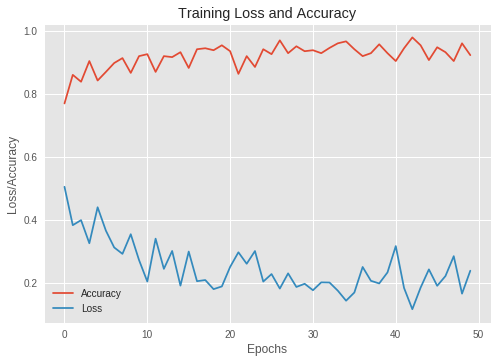

In [140]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [141]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [142]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 58.29%


### 5 tentativa Precision: 47.45%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_5'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [147]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 1.1651 - acc: 0.5750 - val_loss: 0.7766 - val_acc: 0.5312

Epoch 00001: val_loss improved from inf to 0.77656, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 2/50
 - 0s - loss: 1.0820 - acc: 0.6437 - val_loss: 0.7309 - val_acc: 0.6406

Epoch 00002: val_loss improved from 0.77656 to 0.73087, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 3/50
 - 0s - loss: 0.7966 - acc: 0.6906 - val_loss: 1.0350 - val_acc: 0.5938

Epoch 00003: val_loss did not improve from 0.73087
Epoch 4/50
 - 0s - loss: 0.5574 - acc: 0.7938 - val_loss: 1.2529 - val_acc: 0.4531

Epoch 00004: val_loss did not improve from 0.73087
Epoch 5/50
 - 0s - loss: 0.6186 - acc: 0.7875 - val_loss: 0.6987 - val_acc: 0.7344

Epoch 00005: val_loss improved from 0.73087 to 0.69870, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 6/50
 - 0s - loss: 0.4229 - acc: 0.8688 - val_loss: 1.1014 - val_acc: 0.4844

Epoch 00006: val_loss d

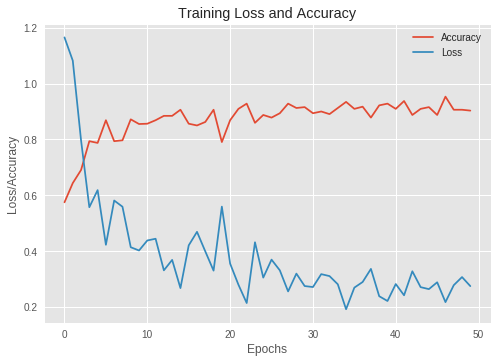

In [148]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [149]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [150]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 47.45%


### 6 tentativa Precision: 35.57%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_6'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [155]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 0.6172 - acc: 0.7344 - val_loss: 2.0658 - val_acc: 0.4688

Epoch 00001: val_loss improved from inf to 2.06582, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.4981 - acc: 0.7969 - val_loss: 0.8045 - val_acc: 0.7031

Epoch 00002: val_loss improved from 2.06582 to 0.80447, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 3/50
 - 0s - loss: 0.3304 - acc: 0.8750 - val_loss: 0.6025 - val_acc: 0.7656

Epoch 00003: val_loss improved from 0.80447 to 0.60249, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 4/50
 - 0s - loss: 0.3604 - acc: 0.8594 - val_loss: 0.7214 - val_acc: 0.8125

Epoch 00004: val_loss did not improve from 0.60249
Epoch 5/50
 - 0s - loss: 0.3553 - acc: 0.8844 - val_loss: 2.0796 - val_acc: 0.4844

Epoch 00005: val_loss did not improve from 0.60249
Epoch 6/50
 - 0s - loss: 0.3260 - acc: 0.8812 - val_loss: 0.9448 - val_acc: 0.6875

Epoch 00006: val_loss d

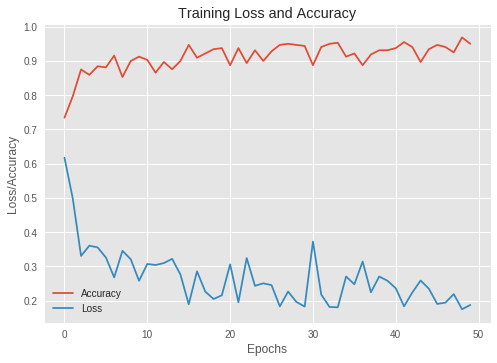

In [156]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [157]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [158]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 35.57%


### 7 tentativa Precision: 75.84%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_7'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [163]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 0.5243 - acc: 0.7438 - val_loss: 1.2001 - val_acc: 0.6406

Epoch 00001: val_loss improved from inf to 1.20007, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 2/50
 - 0s - loss: 0.4916 - acc: 0.8375 - val_loss: 1.0478 - val_acc: 0.7188

Epoch 00002: val_loss improved from 1.20007 to 1.04781, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 3/50
 - 0s - loss: 0.2961 - acc: 0.9062 - val_loss: 1.2981 - val_acc: 0.5156

Epoch 00003: val_loss did not improve from 1.04781
Epoch 4/50
 - 0s - loss: 0.2670 - acc: 0.9219 - val_loss: 0.9689 - val_acc: 0.6875

Epoch 00004: val_loss improved from 1.04781 to 0.96891, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 5/50
 - 0s - loss: 0.3309 - acc: 0.8781 - val_loss: 0.3610 - val_acc: 0.9062

Epoch 00005: val_loss improved from 0.96891 to 0.36100, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 6/50
 - 0s - loss: 0.3419 -

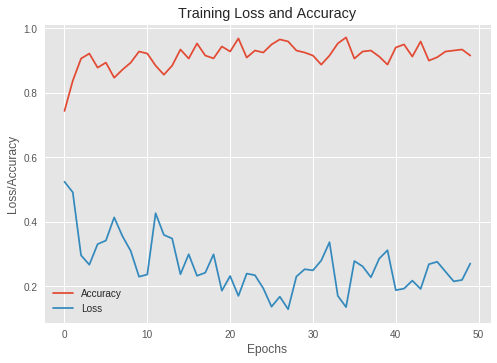

In [164]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [165]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [166]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 75.84%


### 8 tentativa Precision: 62.88%

Modelo adaptado do **Lucas Albertins**

*   Função **Adadelta** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_8'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [171]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 1.1638 - acc: 0.6250 - val_loss: 0.8995 - val_acc: 0.7031

Epoch 00001: val_loss improved from inf to 0.89950, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 0.6986 - acc: 0.8031 - val_loss: 0.6203 - val_acc: 0.6719

Epoch 00002: val_loss improved from 0.89950 to 0.62032, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 3/50
 - 0s - loss: 0.4504 - acc: 0.8500 - val_loss: 0.7674 - val_acc: 0.6719

Epoch 00003: val_loss did not improve from 0.62032
Epoch 4/50
 - 1s - loss: 0.6302 - acc: 0.7500 - val_loss: 0.7706 - val_acc: 0.6406

Epoch 00004: val_loss did not improve from 0.62032
Epoch 5/50
 - 0s - loss: 0.5646 - acc: 0.8281 - val_loss: 0.6161 - val_acc: 0.8125

Epoch 00005: val_loss improved from 0.62032 to 0.61605, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 6/50
 - 1s - loss: 0.4519 - acc: 0.8375 - val_loss: 1.0722 - val_acc: 0.4531

Epoch 00006: val_loss d

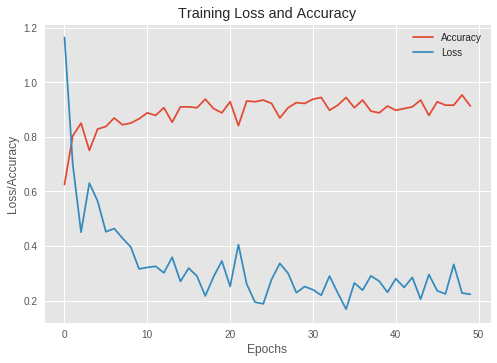

In [172]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [173]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [174]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 62.88%


### 9 tentativa Precision: 43.07%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_9'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [179]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 2.0479 - acc: 0.4937 - val_loss: 0.7120 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 0.71202, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 2/50
 - 1s - loss: 0.6587 - acc: 0.7062 - val_loss: 0.8204 - val_acc: 0.7188

Epoch 00002: val_loss did not improve from 0.71202
Epoch 3/50
 - 0s - loss: 0.5437 - acc: 0.7969 - val_loss: 0.7251 - val_acc: 0.7812

Epoch 00003: val_loss did not improve from 0.71202
Epoch 4/50
 - 0s - loss: 0.5352 - acc: 0.8344 - val_loss: 0.5716 - val_acc: 0.7969

Epoch 00004: val_loss improved from 0.71202 to 0.57158, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 5/50
 - 0s - loss: 0.3452 - acc: 0.8937 - val_loss: 0.6403 - val_acc: 0.6719

Epoch 00005: val_loss did not improve from 0.57158
Epoch 6/50
 - 0s - loss: 0.3216 - acc: 0.8937 - val_loss: 0.9578 - val_acc: 0.4844

Epoch 00006: val_loss did not improve from 0.57158
Epoch 7/50
 - 0s - loss: 0.3978 - acc: 0.8500 

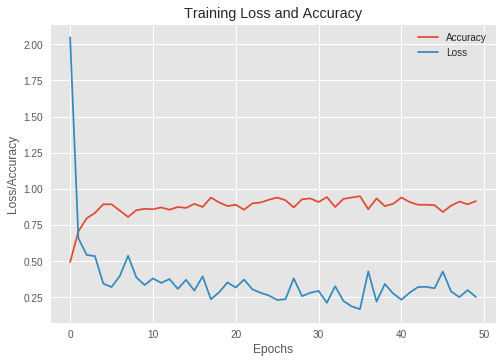

In [180]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [181]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [182]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 43.07%


### 10 tentativa Precision: 73.43%

Modelo adaptado do **Lucas Albertins**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_10'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [187]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 8s - loss: 1.1902 - acc: 0.6031 - val_loss: 0.9242 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 0.92422, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 0.6728 - acc: 0.8125 - val_loss: 0.6754 - val_acc: 0.7188

Epoch 00002: val_loss improved from 0.92422 to 0.67543, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 3/50
 - 1s - loss: 0.6976 - acc: 0.7625 - val_loss: 0.5994 - val_acc: 0.7188

Epoch 00003: val_loss improved from 0.67543 to 0.59938, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 4/50
 - 1s - loss: 0.2907 - acc: 0.8906 - val_loss: 0.6290 - val_acc: 0.7500

Epoch 00004: val_loss did not improve from 0.59938
Epoch 5/50
 - 1s - loss: 0.5164 - acc: 0.8282 - val_loss: 0.4016 - val_acc: 0.8125

Epoch 00005: val_loss improved from 0.59938 to 0.40162, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 6/50
 - 1s - loss: 0.47

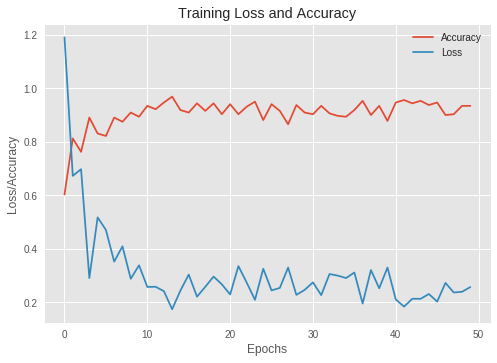

In [188]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [189]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [190]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 73.43%


### 11 tentativa Precision: 77.76%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_11'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [195]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 8s - loss: 1.0777 - acc: 0.6188 - val_loss: 0.7039 - val_acc: 0.5938

Epoch 00001: val_loss improved from inf to 0.70392, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 0.8167 - acc: 0.6844 - val_loss: 0.5762 - val_acc: 0.7812

Epoch 00002: val_loss improved from 0.70392 to 0.57619, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 0.7145 - acc: 0.7125 - val_loss: 0.5546 - val_acc: 0.7344

Epoch 00003: val_loss improved from 0.57619 to 0.55457, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 4/50
 - 1s - loss: 0.6045 - acc: 0.7906 - val_loss: 0.6703 - val_acc: 0.5781

Epoch 00004: val_loss did not improve from 0.55457
Epoch 5/50
 - 1s - loss: 0.4560 - acc: 0.8500 - val_loss: 0.4205 - val_acc: 0.8750

Epoch 00005: val_loss improved from 0.55457 to 0.42053, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 6/50
 - 1s - loss: 0.44

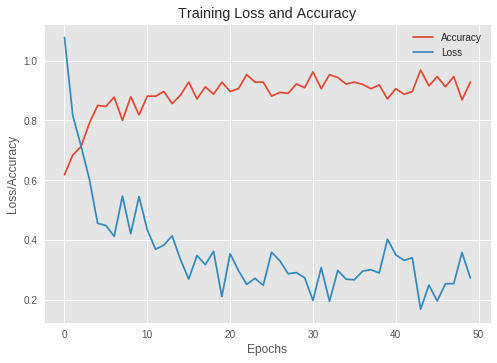

In [196]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [197]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [198]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 77.76%


### 12 tentativa Precision: 71.85%

Modelo adaptado do **Lucas Albertins**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_12'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [203]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 8s - loss: 1.2209 - acc: 0.5781 - val_loss: 0.5452 - val_acc: 0.7188

Epoch 00001: val_loss improved from inf to 0.54518, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 0.7901 - acc: 0.7031 - val_loss: 0.9458 - val_acc: 0.6250

Epoch 00002: val_loss did not improve from 0.54518
Epoch 3/50
 - 1s - loss: 0.5478 - acc: 0.8063 - val_loss: 0.6003 - val_acc: 0.7344

Epoch 00003: val_loss did not improve from 0.54518
Epoch 4/50
 - 1s - loss: 0.4753 - acc: 0.8031 - val_loss: 0.5875 - val_acc: 0.6719

Epoch 00004: val_loss did not improve from 0.54518
Epoch 5/50
 - 1s - loss: 0.3704 - acc: 0.8781 - val_loss: 0.3952 - val_acc: 0.9219

Epoch 00005: val_loss improved from 0.54518 to 0.39520, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 6/50
 - 1s - loss: 0.6030 - acc: 0.7750 - val_loss: 0.7102 - val_acc: 0.6562

Epoch 00006: val_loss did not improve from 0.39520
Epoch 7/50
 - 1s - loss: 0.3535 - acc: 0.875

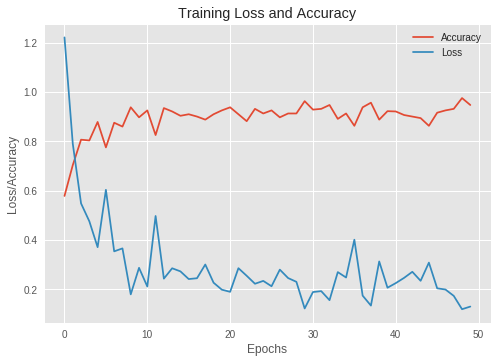

In [204]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [205]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [206]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 71.85%
